# **1. Perkenalan Dataset**


Pembuatan model Clustering dengan menggunakan rekapitulasi pasar harga saham Indonesia :

1. **Sumber Dataset**:  
   Dataset diperoleh melalui platform dengan mengekstrak data yang diperoleh dari Indeks Harga Saham Gabungan (IHSG)
   sumber : https://www.kaggle.com/datasets/muamkh/ihsgstockdata?select=DaftarSaham.csv
   
2. **Konten Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

# **2. Import Library**

Pada tahap ini perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# **3. Load Dataset**

Pada tahap ini dilakukan load dataset dari local dengan mengupload file(".CSV") ke dalam environtment Google Collab

In [2]:
data = pd.read_csv('/content/IHSG_market.csv')
data.head()

,timestamp,open,low,high,close,volume,code,Name,Sector
0,2022-06-01,50,50,50,50,0,AKKU,Anugerah Kagum Karya Utama Tbk,Consumer Cyclicals
1,2022-06-02,50,50,50,50,5100,AKKU,Anugerah Kagum Karya Utama Tbk,Consumer Cyclicals
2,2022-06-03,50,50,50,50,1000,AKKU,Anugerah Kagum Karya Utama Tbk,Consumer Cyclicals
3,2022-06-06,50,50,50,50,1200,AKKU,Anugerah Kagum Karya Utama Tbk,Consumer Cyclicals
4,2022-06-07,50,50,50,50,300,AKKU,Anugerah Kagum Karya Utama Tbk,Consumer Cyclicals


# **4. Exploratory Data Analysis (EDA)**

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*)

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.


In [3]:
# Ekstraksi fitur
df = data[['timestamp', 'code', 'Name', 'open', 'high', 'low', 'close', 'Sector']]
df["PrevClose"] = df["close"].shift(1)
df["DifPriceCurrentage"] = (df["close"] - df["open"]) / df["open"] * 100
df['DifPricePreviousage'] = (df['close'] - df['PrevClose']) / df['PrevClose'] * 100
df['Volatile'] = df['high'] - df['low']
df.drop(columns=['PrevClose'], inplace=True)

In [4]:
df = df[df['timestamp'] != '2022-06-01']

In [5]:
df.drop(columns=['timestamp', 'code', 'Name'], inplace=True)

## **4.1. Memahami Struktur Data**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125834 entries, 1 to 126614
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   open                 125834 non-null  int64  
 1   high                 125834 non-null  int64  
 2   low                  125834 non-null  int64  
 3   close                125834 non-null  int64  
 4   Sector               125834 non-null  object 
 5   DifPriceCurrentage   125834 non-null  float64
 6   DifPricePreviousage  125834 non-null  float64
 7   Volatile             125834 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 8.6+ MB


## **4.2. Menangani Data Hilang**

In [7]:
df.isna().sum()

,0
open,0
high,0
low,0
close,0
Sector,0
DifPriceCurrentage,0
DifPricePreviousage,0
Volatile,0


## **4.3. Analisa Deskriptif dan Korelasi**

In [8]:
num_features = df.select_dtypes(include=['number'])
num_features.describe()

,open,high,low,close,DifPriceCurrentage,DifPricePreviousage,Volatile
count,125834.000000,125834.000000,125834.000000,125834.000000,1.258340e+05,125834.000000,125834.000000
mean,1515.435049,1535.711255,1494.710261,1515.010140,inf,-0.018834,41.000993
std,4390.932429,4441.104332,4352.857190,4395.337665,NaN,4.321640,154.540892
min,0.000000,0.000000,0.000000,23.000000,-3.086420e+01,-99.357895,0.000000
25%,119.000000,123.000000,117.000000,119.000000,-1.231338e+00,-1.010101,2.000000
50%,312.000000,318.000000,306.000000,310.000000,0.000000e+00,0.000000,10.000000
75%,1080.000000,1100.000000,1060.000000,1080.000000,6.436043e-01,0.628931,30.000000
max,94375.000000,97500.000000,92550.000000,94500.000000,inf,417.241379,11200.000000


In [9]:
num_features.corr()

,open,high,low,close,DifPriceCurrentage,DifPricePreviousage,Volatile
open,1.000000,0.999685,0.999853,0.999732,0.005760,0.000285,0.566114
high,0.999685,1.000000,0.999584,0.999796,0.010289,0.003403,0.582753
low,0.999853,0.999584,1.000000,0.999781,0.008290,0.001734,0.559064
close,0.999732,0.999796,0.999781,1.000000,0.012587,0.004763,0.571345
DifPriceCurrentage,0.005760,0.010289,0.008290,0.012587,1.000000,0.604310,0.062194
DifPricePreviousage,0.000285,0.003403,0.001734,0.004763,0.604310,1.000000,0.048935
Volatile,0.566114,0.582753,0.559064,0.571345,0.062194,0.048935,1.000000


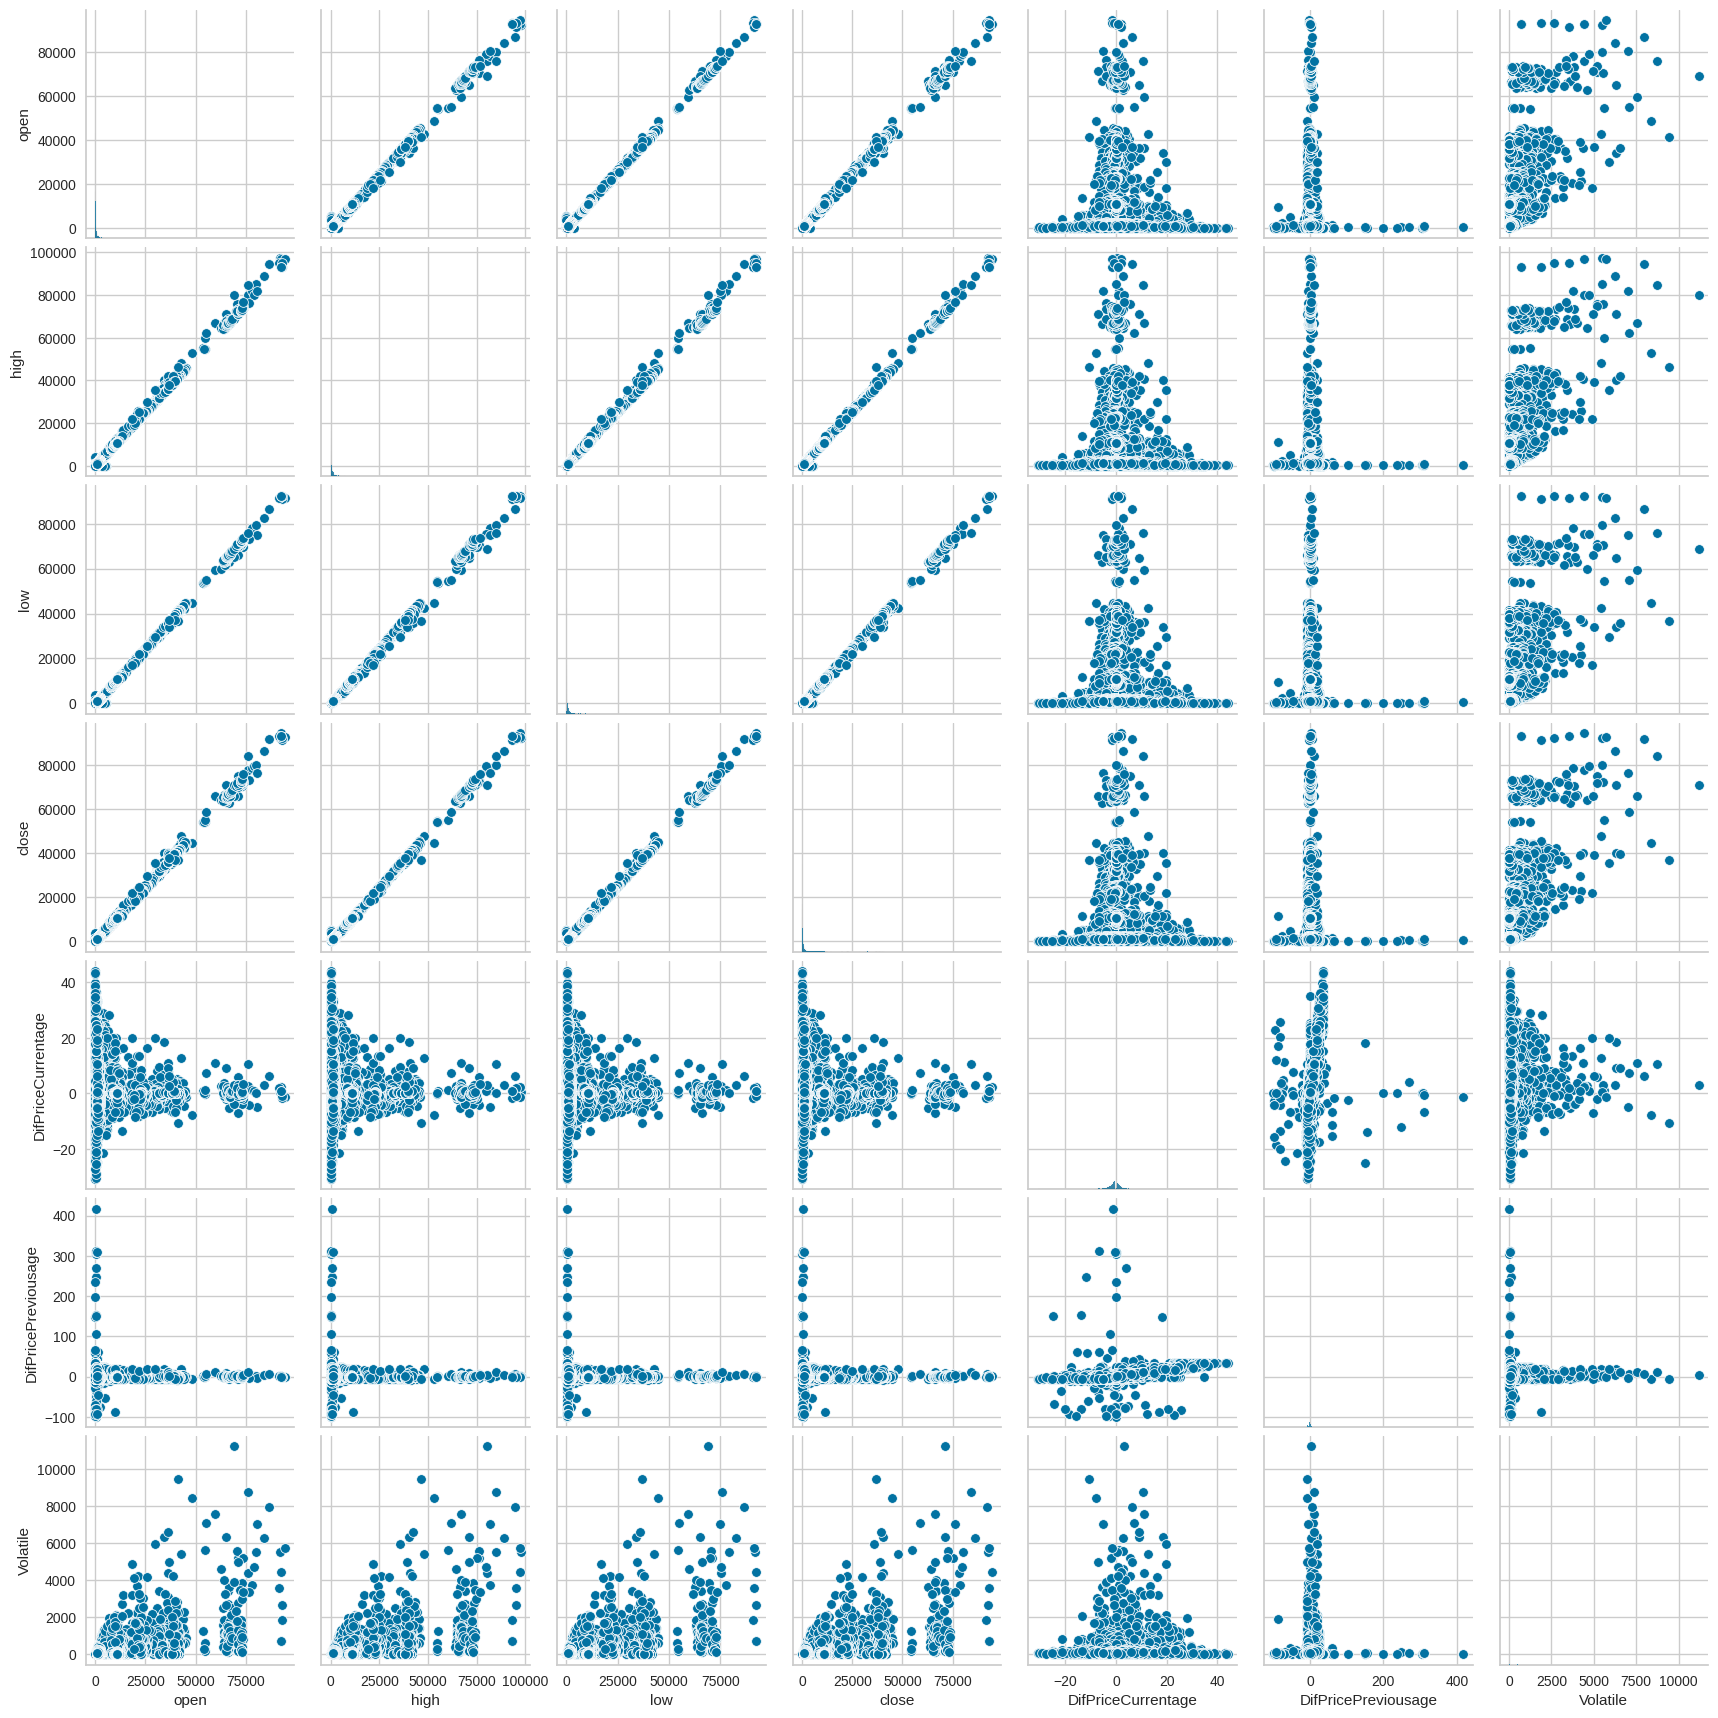

In [10]:
# Grafik korelasi antar feature
sns.pairplot(num_features)
plt.show()

In [11]:
cat_feature = df.groupby(by='Sector').size().reset_index(name='count').sort_values(by='count', ascending=False)
cat_feature.head()

,Sector,count
1,Consumer Cyclicals,21289
2,Consumer Non-Cyclicals,17169
4,Financials,16472
0,Basic Materials,14870
8,Properties & Real Estate,12882


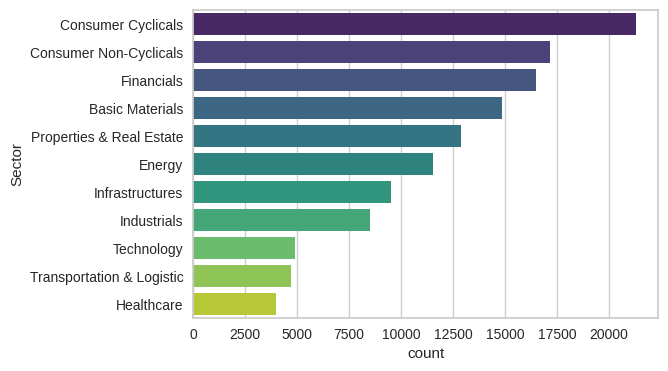

In [12]:
plt.figure(figsize=(6, 4))
sns.barplot(
    x='count',
    y='Sector',
    data=cat_feature,
    palette='viridis',
    hue='Sector'
)

plt.show()

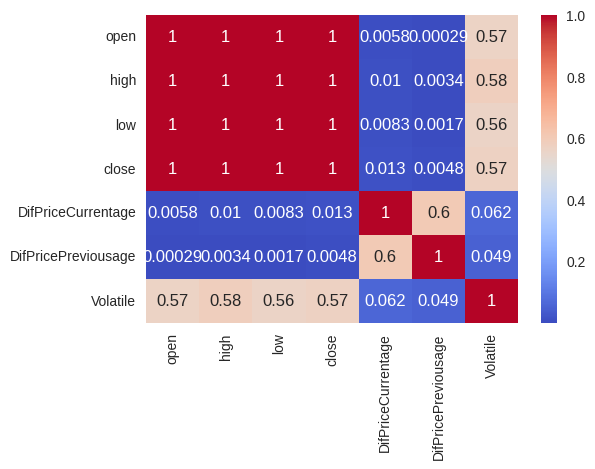

In [13]:
# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    num_features.corr(),
    annot=True,
    cmap='coolwarm')
plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah.

## **5.1. Menangani Missing Value**

In [14]:
df.dropna(inplace=True)
df.isna().sum()

,0
open,0
high,0
low,0
close,0
Sector,0
DifPriceCurrentage,0
DifPricePreviousage,0
Volatile,0


## **5.2. Menagani Duplikasi Data**

In [15]:
print("Duplikasi data : ", df.duplicated().sum())

Duplikasi data :  27247


In [16]:
# Menghapus duplikasi data
df_1 = df.drop_duplicates()
print("Duplikasi data : ", df_1.duplicated().sum())

Duplikasi data :  0


In [17]:
num_features_1 = df_1.select_dtypes(include=['number'])
num_features_name = num_features_1.columns

Q1 = num_features_1.quantile(0.25)
Q3 = num_features_1.quantile(0.75)
IQR = Q3 - Q1
df_1 = df_1[~((num_features_1 < (Q1 - 1.5 * IQR)) | (num_features_1 > (Q3 + 1.5 * IQR))).any(axis=1)]
df_1.head()

,open,high,low,close,Sector,DifPriceCurrentage,DifPricePreviousage,Volatile
1,50,50,50,50,Consumer Cyclicals,0.000000,0.000000,0
164,2720,2740,2660,2680,Industrials,-1.470588,-1.831502,80
165,2680,2680,2600,2610,Industrials,-2.611940,-2.611940,80
175,2380,2400,2320,2360,Industrials,-0.840336,0.000000,80
176,2360,2400,2320,2390,Industrials,1.271186,1.271186,80


## **5.3. Normalisai atau Standarisasi Fitur**

In [18]:
# Standarisasi Data
import numpy as np

num_features_1 = df_1.select_dtypes(include=['number'])
num_features_name = num_features_1.columns
pt = StandardScaler()

# Mengatasi masalah dataset mengandung data infinite dan extreme large(1e10)
if np.isinf(num_features_1).any().any():
    print("Infinite values found. Replacing them with NaN.")
    num_features_1 = num_features_1.replace([np.inf, -np.inf], np.nan)

if (num_features_1.abs() > 1e10).any().any():
    print("Extremely large values found. Clipping them.")
    num_features_1 = num_features_1.clip(lower=-1e10, upper=1e10)

num_features_1.fillna(num_features_1.median(), inplace=True)
num_features_1.mean()

,0
open,578.611195
high,586.211731
low,568.867494
close,577.117998
DifPriceCurrentage,-0.327723
DifPricePreviousage,-0.222284
Volatile,17.344237


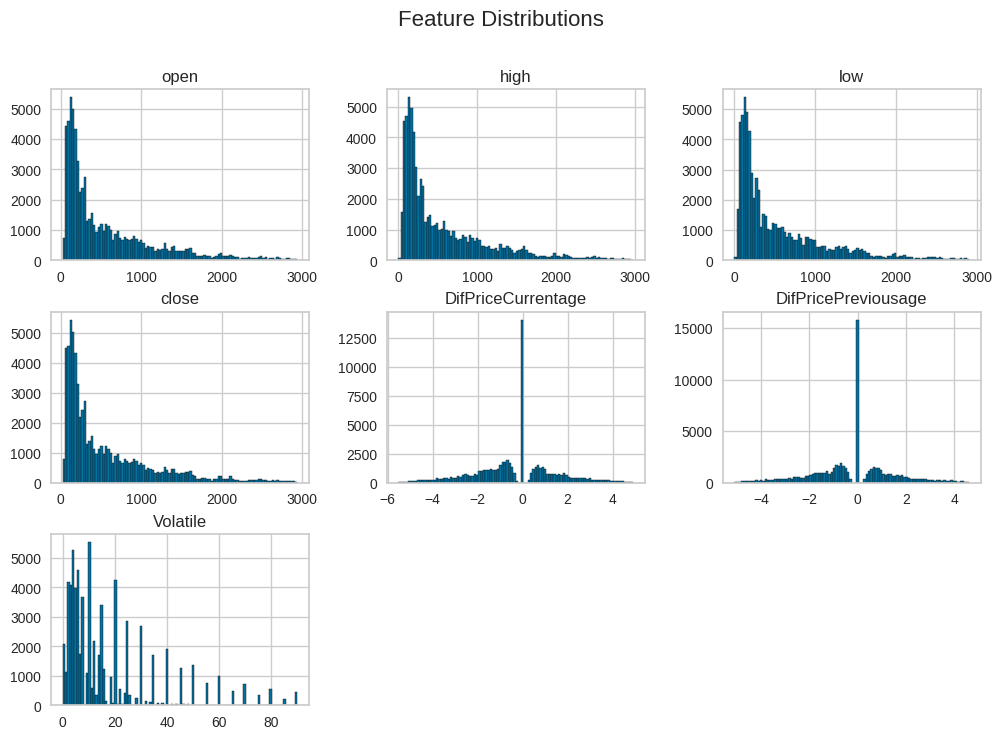

In [19]:
num_features_1.hist(figsize=(12, 8), bins=100, edgecolor='k')
plt.suptitle('Feature Distributions', fontsize=16)
plt.show()

In [20]:
num_features_standardized = pd.DataFrame(pt.fit_transform(num_features_1), columns=num_features_1.columns)
num_features_standardized.mean()

,0
open,-5.049186e-17
high,6.010936e-17
low,-6.171228e-17
close,7.854290e-17
DifPriceCurrentage,-1.342442e-17
DifPricePreviousage,7.213123e-18
Volatile,1.362479e-17


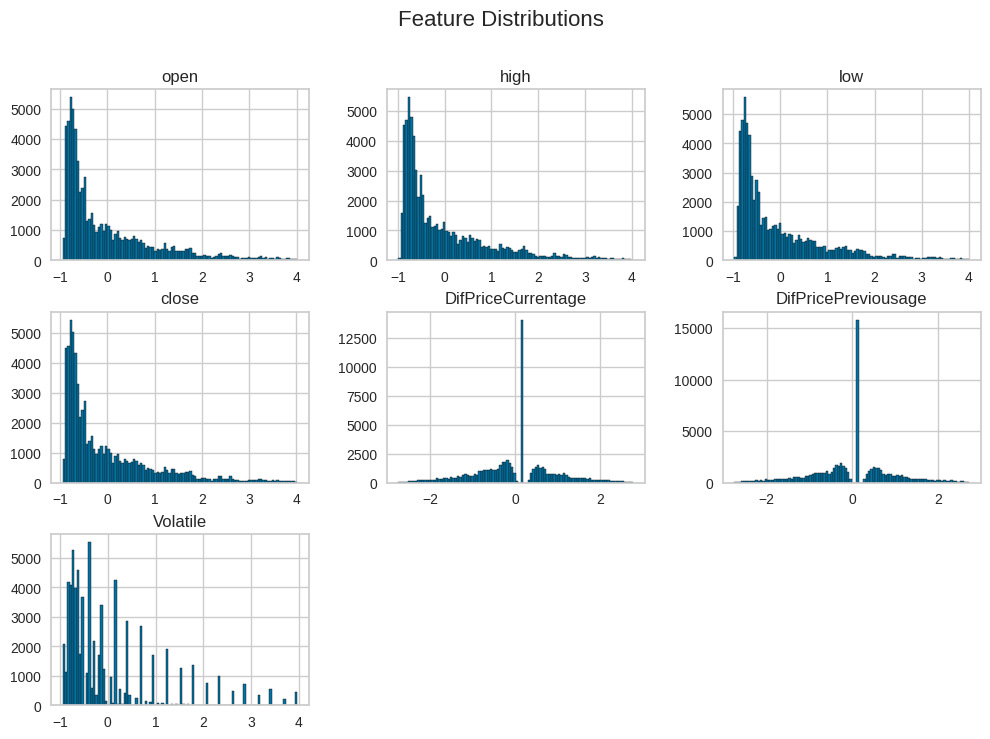

In [21]:
num_features_standardized.hist(figsize=(12, 8), bins=100, edgecolor='k')
plt.suptitle('Feature Distributions', fontsize=16)
plt.show()

## **5.4. Encoding data kategorik**

In [22]:
cat_feature_1 = df_1.select_dtypes(include=['object'])
cat_feature_1 = pd.get_dummies(cat_feature_1)
cat_feature_1.head()

,Sector_Basic Materials,Sector_Consumer Cyclicals,Sector_Consumer Non-Cyclicals,Sector_Energy,Sector_Financials,Sector_Healthcare,Sector_Industrials,Sector_Infrastructures,Sector_Properties & Real Estate,Sector_Technology,Sector_Transportation & Logistic
1,False,True,False,False,False,False,False,False,False,False,False
164,False,False,False,False,False,False,True,False,False,False,False
165,False,False,False,False,False,False,True,False,False,False,False
175,False,False,False,False,False,False,True,False,False,False,False
176,False,False,False,False,False,False,True,False,False,False,False


In [23]:
df_1 = pd.concat([num_features_standardized, cat_feature_1], axis=1)
df_1.dropna(inplace=True)
df_1.head()

,open,high,low,close,DifPriceCurrentage,DifPricePreviousage,Volatile,Sector_Basic Materials,Sector_Consumer Cyclicals,Sector_Consumer Non-Cyclicals,Sector_Energy,Sector_Financials,Sector_Healthcare,Sector_Industrials,Sector_Infrastructures,Sector_Properties & Real Estate,Sector_Technology,Sector_Transportation & Logistic
1,3.638547,3.626967,3.595815,3.578826,-0.605090,-0.908431,3.428796,False,True,False,False,False,False,False,False,False,False,False
164,-0.514183,-0.512291,-0.507041,-0.509059,0.557172,0.534554,-0.511357,False,False,False,False,False,False,True,False,False,False,False
165,0.682021,0.696817,0.689769,0.694161,0.443640,1.595581,0.692578,False,False,False,False,False,False,True,False,False,False,False
175,0.478123,0.503158,0.483423,0.464409,-0.442126,-0.530932,0.966200,False,False,False,False,False,False,True,False,False,False,False
176,0.316703,0.385278,0.311467,0.336769,0.865604,-1.978309,2.607931,False,False,False,False,False,False,True,False,False,False,False


# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [24]:
kmeans = KMeans(n_clusters=3, random_state=11)
kmeans.fit(df_1)

KMeans(n_clusters=3, random_state=11)

In [25]:
labels = kmeans.labels_
df_1['Cluster'] = labels
df_1.head()

,open,high,low,close,DifPriceCurrentage,DifPricePreviousage,Volatile,Sector_Basic Materials,Sector_Consumer Cyclicals,Sector_Consumer Non-Cyclicals,Sector_Energy,Sector_Financials,Sector_Healthcare,Sector_Industrials,Sector_Infrastructures,Sector_Properties & Real Estate,Sector_Technology,Sector_Transportation & Logistic,Cluster
1,3.638547,3.626967,3.595815,3.578826,-0.605090,-0.908431,3.428796,False,True,False,False,False,False,False,False,False,False,False,2
164,-0.514183,-0.512291,-0.507041,-0.509059,0.557172,0.534554,-0.511357,False,False,False,False,False,False,True,False,False,False,False,0
165,0.682021,0.696817,0.689769,0.694161,0.443640,1.595581,0.692578,False,False,False,False,False,False,True,False,False,False,False,0
175,0.478123,0.503158,0.483423,0.464409,-0.442126,-0.530932,0.966200,False,False,False,False,False,False,True,False,False,False,False,1
176,0.316703,0.385278,0.311467,0.336769,0.865604,-1.978309,2.607931,False,False,False,False,False,False,True,False,False,False,False,2


## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

In [26]:
# Silhoutte Score
sil = silhouette_score(df_1, labels)
print("Silhouette Score: ", sil)

Silhouette Score:  0.27944795568522907


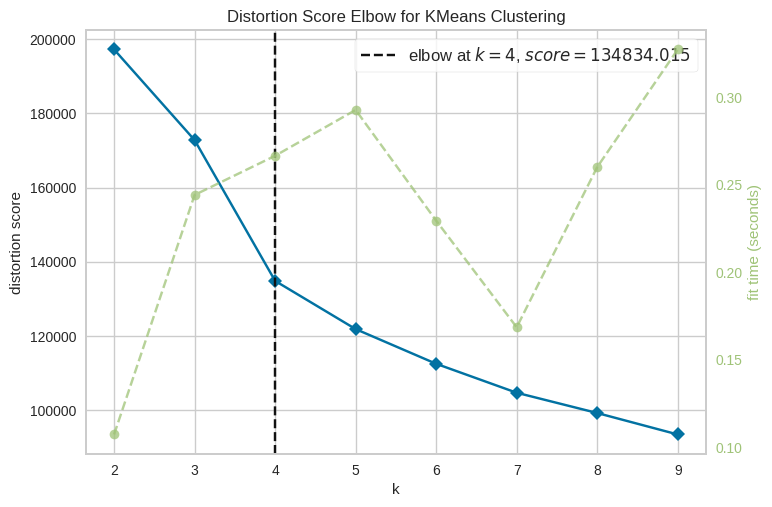

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
# Elbow Method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(df_1)
visualizer.show()

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

#### **High-Correlation Feture Reduction**

In [28]:
# Feature Selection
# Menghapus fitur yang memiliki korelasi yang tinggi satu sama lain

df_2 = df_1.drop(columns=[
    'open',
    'low',
    'high'
])
df_2.head()

,close,DifPriceCurrentage,DifPricePreviousage,Volatile,Sector_Basic Materials,Sector_Consumer Cyclicals,Sector_Consumer Non-Cyclicals,Sector_Energy,Sector_Financials,Sector_Healthcare,Sector_Industrials,Sector_Infrastructures,Sector_Properties & Real Estate,Sector_Technology,Sector_Transportation & Logistic,Cluster
1,3.578826,-0.605090,-0.908431,3.428796,False,True,False,False,False,False,False,False,False,False,False,2
164,-0.509059,0.557172,0.534554,-0.511357,False,False,False,False,False,False,True,False,False,False,False,0
165,0.694161,0.443640,1.595581,0.692578,False,False,False,False,False,False,True,False,False,False,False,0
175,0.464409,-0.442126,-0.530932,0.966200,False,False,False,False,False,False,True,False,False,False,False,1
176,0.336769,0.865604,-1.978309,2.607931,False,False,False,False,False,False,True,False,False,False,False,2


In [29]:
# Melatih model
kmeans = KMeans(n_clusters=4, random_state=11) # jumlah cluster menjadi 5
kmeans.fit(df_2)

KMeans(n_clusters=4, random_state=11)

In [30]:
labels2 = kmeans.labels_
df_2['Cluster'] = labels2
df_2.head()

,close,DifPriceCurrentage,DifPricePreviousage,Volatile,Sector_Basic Materials,Sector_Consumer Cyclicals,Sector_Consumer Non-Cyclicals,Sector_Energy,Sector_Financials,Sector_Healthcare,Sector_Industrials,Sector_Infrastructures,Sector_Properties & Real Estate,Sector_Technology,Sector_Transportation & Logistic,Cluster
1,3.578826,-0.605090,-0.908431,3.428796,False,True,False,False,False,False,False,False,False,False,False,2
164,-0.509059,0.557172,0.534554,-0.511357,False,False,False,False,False,False,True,False,False,False,False,3
165,0.694161,0.443640,1.595581,0.692578,False,False,False,False,False,False,True,False,False,False,False,0
175,0.464409,-0.442126,-0.530932,0.966200,False,False,False,False,False,False,True,False,False,False,False,1
176,0.336769,0.865604,-1.978309,2.607931,False,False,False,False,False,False,True,False,False,False,False,2


In [31]:
# Silhoutte score
sil2 = silhouette_score(df_2, labels2)
print("Silhouette Score After Feature Selection: ", sil2)
print("Silhouette Score Before Feature Selection: ", sil)

Silhouette Score After Feature Selection:  0.3479399849759273
Silhouette Score Before Feature Selection:  0.27944795568522907


#### **Metode PCA untuk Redundan Feature**

In [32]:
# Menggunakan teknik PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_3 = pca.fit_transform(df_1)
df_3 = pd.DataFrame(df_3, columns=['PC1', 'PC2'])
df_3.head()

,PC1,PC2
0,7.954411,-0.895792
1,-1.335855,0.866160
2,1.249064,1.661863
3,1.210456,-0.673529
4,1.765419,-1.050001


In [33]:
# Melatih model
kmeans = KMeans(n_clusters=4, random_state=11)
kmeans.fit(df_3)

KMeans(n_clusters=4, random_state=11)

In [34]:
labels3 = kmeans.labels_
df_3['Cluster'] = labels3
df_3.head()

,PC1,PC2,Cluster
0,7.954411,-0.895792,1
1,-1.335855,0.866160,0
2,1.249064,1.661863,3
3,1.210456,-0.673529,3
4,1.765419,-1.050001,3


In [35]:
# Silhoutte score
sil3 = silhouette_score(df_3, labels3)
print("Silhouette Score After PCA: ", sil3)
print("Silhoutte Score After High-Corr Reduction", sil2)
print("Silhouette Score Before Feature Selection: ", sil)

Silhouette Score After PCA:  0.5495739683776387
Silhoutte Score After High-Corr Reduction 0.3479399849759273
Silhouette Score Before Feature Selection:  0.27944795568522907


## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

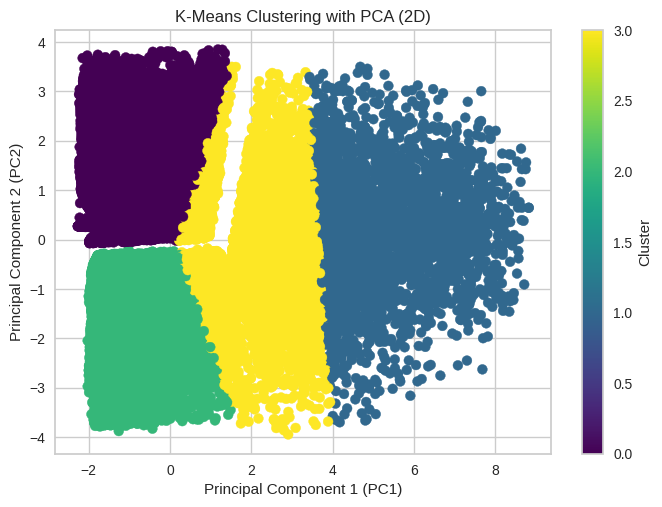

In [36]:
plt.scatter(df_3['PC1'], df_3['PC2'], c=labels3, cmap='viridis', s=50)
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('K-Means Clustering with PCA (2D)')
plt.colorbar(label='Cluster')
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

### Interpretasi Target

**Tutorial: Melakukan Inverse Transform pada Data Target Setelah Clustering**

Setelah melakukan clustering dengan model **KMeans**, kita perlu mengembalikan data yang telah diubah (normalisasi, standarisasi, atau label encoding) ke bentuk aslinya. Berikut adalah langkah-langkahnya.

---

**1. Tambahkan Hasil Label Cluster ke DataFrame**
Setelah mendapatkan hasil clustering, kita tambahkan label cluster ke dalam DataFrame yang telah dinormalisasi.

```python
df_normalized['Cluster'] = model_kmeans.labels_
```

Lakukan Inverse Transform pada feature yang sudah dilakukan Labelisasi dan Standararisasi. Berikut code untuk melakukannya:
label_encoder.inverse_transform(X_Selected[['Fitur']])

Lalu masukkan ke dalam kolom dataset asli atau membuat dataframe baru
```python
df_normalized['Fitur'] = label_encoder.inverse_transform(df_normalized[['Fitur']])
```
Masukkan Data yang Sudah Di-Inverse ke dalam Dataset Asli atau Buat DataFrame Baru
```python
df_original['Fitur'] = df_normalized['Fitur']
```

In [37]:
# Inverse pada df_3 pasca PCA model
# dan membuat dataframe baru yang memiliki data dan cluster

# df_1.drop(columns=['Cluster'], inplace=True)
all_feature = df_1.columns
# df_3.drop(columns=['Cluster'], inplace=True)
new_df = df_1.copy()
new_df.columns = all_feature
new_df['Cluster'] = labels3
new_df.head()

,open,high,low,close,DifPriceCurrentage,DifPricePreviousage,Volatile,Sector_Basic Materials,Sector_Consumer Cyclicals,Sector_Consumer Non-Cyclicals,Sector_Energy,Sector_Financials,Sector_Healthcare,Sector_Industrials,Sector_Infrastructures,Sector_Properties & Real Estate,Sector_Technology,Sector_Transportation & Logistic,Cluster
1,3.638547,3.626967,3.595815,3.578826,-0.605090,-0.908431,3.428796,False,True,False,False,False,False,False,False,False,False,False,1
164,-0.514183,-0.512291,-0.507041,-0.509059,0.557172,0.534554,-0.511357,False,False,False,False,False,False,True,False,False,False,False,0
165,0.682021,0.696817,0.689769,0.694161,0.443640,1.595581,0.692578,False,False,False,False,False,False,True,False,False,False,False,3
175,0.478123,0.503158,0.483423,0.464409,-0.442126,-0.530932,0.966200,False,False,False,False,False,False,True,False,False,False,False,3
176,0.316703,0.385278,0.311467,0.336769,0.865604,-1.978309,2.607931,False,False,False,False,False,False,True,False,False,False,False,3


In [38]:
# Inverse Label Encoder

new_df['Sector'] = new_df.filter(like='Sector_').idxmax(axis=1).str.replace('Sector_', '')
new_df = new_df.drop(columns=new_df.filter(like='Sector_').columns)
new_df.head()

,open,high,low,close,DifPriceCurrentage,DifPricePreviousage,Volatile,Cluster,Sector
1,3.638547,3.626967,3.595815,3.578826,-0.605090,-0.908431,3.428796,1,Consumer Cyclicals
164,-0.514183,-0.512291,-0.507041,-0.509059,0.557172,0.534554,-0.511357,0,Industrials
165,0.682021,0.696817,0.689769,0.694161,0.443640,1.595581,0.692578,3,Industrials
175,0.478123,0.503158,0.483423,0.464409,-0.442126,-0.530932,0.966200,3,Industrials
176,0.316703,0.385278,0.311467,0.336769,0.865604,-1.978309,2.607931,3,Industrials


### Inverse Data Jika Melakukan Normalisasi/Standardisasi

Inverse Transform untuk Data yang Distandarisasi
Jika data numerik telah dinormalisasi menggunakan StandardScaler atau MinMaxScaler, kita bisa mengembalikannya ke skala asli:
```python
df_normalized[['Fitur_Numerik']] = scaler.inverse_transform(df_normalized[['Fitur_Numerik']])
```

In [39]:
# Inverse data numeric yang sudah distandarisasi

new_df[num_features_1.columns] = pt.inverse_transform(new_df[num_features_1.columns])
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40451 entries, 1 to 70924
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   open                 40451 non-null  float64
 1   high                 40451 non-null  float64
 2   low                  40451 non-null  float64
 3   close                40451 non-null  float64
 4   DifPriceCurrentage   40451 non-null  float64
 5   DifPricePreviousage  40451 non-null  float64
 6   Volatile             40451 non-null  float64
 7   Cluster              40451 non-null  int32  
 8   Sector               40451 non-null  object 
dtypes: float64(7), int32(1), object(1)
memory usage: 2.9+ MB


Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [54]:
# Analisis Cluster

new_df.groupby(by="Cluster").agg({
    "DifPriceCurrentage": ["mean", "max", "min"],
    "DifPricePreviousage": ["mean", "max", "min"],
    "Volatile": ["mean", "max", "min"],
    "Sector": lambda x: x.mode().iloc[0]
})

DifPriceCurrentage                     DifPricePreviousage            \
                      mean       max       min                mean       max   
Cluster                                                                        
0                 0.926123  4.918033 -4.651163            0.913967  4.621849   
1                -0.086039  4.838710 -5.362776           -0.005303  4.615385   
2                -2.046363  2.890173 -5.523810           -1.738510  4.444444   
3                -0.411153  4.918033 -5.494505           -0.317544  4.597701   

                    Volatile                               Sector  
              min       mean   max  min                  <lambda>  
Cluster                                                            
0       -4.166667  10.331873  85.0  0.0        Consumer Cyclicals  
1       -5.105105  49.199885  90.0  0.0    Consumer Non-Cyclicals  
2       -5.113636  10.759597  80.0  0.0        Consumer Cyclicals  
3       -5.106383  29.725374  90.0  0.0  Properties & Real Estate

Tulis hasil interpretasinya di sini.  
# Analisis Karakteristik Cluster dari Model KMeans

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans.
1. Cluster 1:
- **Pada analisis perbuhan yang terjadi dalam satu hari (DifPriceCurrentage), kelompok ini memiliki nilai :**  
    mean: 0.92%  
    max: 4.91%  
    min: -4.65%  
- **Pada analisis perubahan yang terjadi terhadap hari sebelumnya (DifPricePreviousage), kelompok ini memiliki nilai :**  
    mean: 0.91%  
    max: 4.62%  
    min: -4.16%  
- **Pada analisis tinggi rendahnya transaksi yang terjadi dalam satu hari (Volatile), kelompok ini memiliki nilai :)**  
    mean: 10.33  
    max: 85  
    min: 0.0  
- **Analisis:** Cluster memiliki peningkatan return stabil dan positif dengan nilai volatile yang kecil (Stable-Positive)  
2. Cluster 2:  
- **Pada analisis perbuhan yang terjadi dalam satu hari (DifPriceCurrentage), kelompok ini memiliki nilai :**  
    mean: -0.08%  
    max: 4.83%  
    min: -5.36%  
- **Pada analisis perubahan yang terjadi terhadap hari sebelumnya (DifPricePreviousage), kelompok ini memiliki nilai :**  
    mean: 0.01%  
    max: 4.61%  
    min: -5.11%  
- **Pada analisis tinggi rendahnya transaksi yang terjadi dalam satu hari (Volatile), kelompok ini memiliki nilai :**  
    mean: 49.19  
    max: 90.0  
    min: 0.0  
- **Analisis: ** Cluster memiliki trend return yang cukup imbang namun dengan nilai volatile yang tinggi (High-Volatility)
3. Cluster 3:  
- **Pada analisis perbuhan yang terjadi dalam satu hari (DifPriceCurrentage), kelompok ini memiliki nilai :**  
    mean: -2.04%  
    max: 2.89%  
    min: -5.52%  
- **Pada analisis perubahan yang terjadi terhadap hari sebelumnya (DifPricePreviousage), kelompok ini memiliki nilai :**  
    mean: -1.73%  
    max: 4.44%  
    min: -5.11%  
- **Pada analisis tinggi rendahnya transaksi yang terjadi dalam satu hari (Volatile), kelompok ini memiliki nilai :**  
    mean: 10.75  
    max: 80.0  
    min: 0.0  
- **Analisis: ** Cluster ini memiliki trend penurunan yang cukup signifikan dengan nilai volatile yang rendah (Downward-Trend)

4. Cluster 4:  
- **Pada analisis perbuhan yang terjadi dalam satu hari (DifPriceCurrentage), kelompok ini memiliki nilai :**  
    mean: -0.41%  
    max: 4.91%  
    min: -5.49%  
- **Pada analisis perubahan yang terjadi terhadap hari sebelumnya (DifPricePreviousage), kelompok ini memiliki nilai :**  
    mean: -0.31%  
    max: 4.59%  
    min: -5.11%  
- **Pada analisis tinggi rendahnya transaksi yang terjadi dalam satu hari (Volatile), kelompok ini memiliki nilai :)**  
    mean: 29.72  
    max: 90.0  
    min: 0.0  
- **Analisis: ** Cluster ini memiliki penurunan trend yang kecil dengan tingkat volatile yang moderate (Midloss-ModerateVoletile)

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [58]:
new_df = new_df.drop(columns=['timestamp', 'code', 'Name', 'volume'], errors='ignore')

# Merge
new_df = pd.merge(
    left=new_df,
    right=data[['timestamp', 'code', 'Name', 'volume']],
    how='left',
    left_index=True,
    right_index=True
)

new_df.head()

,open,high,low,close,DifPriceCurrentage,DifPricePreviousage,Volatile,Sector,Cluster,timestamp,code,Name,volume
1,2720.0,2740.0,2660.0,2680.0,-1.470588,-1.831502,80.0,Consumer Cyclicals,1,2022-06-02,AKKU,Anugerah Kagum Karya Utama Tbk,5100
164,276.0,282.0,274.0,278.0,0.724638,0.724638,8.0,Industrials,0,2022-06-09,ABMM,ABM Investama Tbk.,4767800
165,980.0,1000.0,970.0,985.0,0.510204,2.604167,30.0,Industrials,3,2022-06-10,ABMM,ABM Investama Tbk.,3162500
175,860.0,885.0,850.0,850.0,-1.162791,-1.162791,35.0,Industrials,3,2022-06-24,ABMM,ABM Investama Tbk.,1411000
176,765.0,815.0,750.0,775.0,1.307190,-3.726708,65.0,Industrials,3,2022-06-27,ABMM,ABM Investama Tbk.,2731300


In [62]:
all_feature = ['timestamp', 'code', 'Name', 'open', 'high', 'low', 'close', 'DifPriceCurrentage', 'DifPricePreviousage', 'Volatile', 'Sector', 'Cluster']
new_df = new_df[all_feature]
new_df.head()

,timestamp,code,Name,open,high,low,close,DifPriceCurrentage,DifPricePreviousage,Volatile,Sector,Cluster
1,2022-06-02,AKKU,Anugerah Kagum Karya Utama Tbk,2720.0,2740.0,2660.0,2680.0,-1.470588,-1.831502,80.0,Consumer Cyclicals,1
164,2022-06-09,ABMM,ABM Investama Tbk.,276.0,282.0,274.0,278.0,0.724638,0.724638,8.0,Industrials,0
165,2022-06-10,ABMM,ABM Investama Tbk.,980.0,1000.0,970.0,985.0,0.510204,2.604167,30.0,Industrials,3
175,2022-06-24,ABMM,ABM Investama Tbk.,860.0,885.0,850.0,850.0,-1.162791,-1.162791,35.0,Industrials,3
176,2022-06-27,ABMM,ABM Investama Tbk.,765.0,815.0,750.0,775.0,1.307190,-3.726708,65.0,Industrials,3


In [71]:
new_df['Cluster'] = new_df['Cluster'].astype(str)
new_df['Cluster'] = new_df['Cluster'].replace({
    '0': 'Stable-Positive',
    '1': 'High-Volatility',
    '2': 'Downward-Trend',
    '3': 'Mildloss-ModerateVolatile'})
new_df.reset_index(drop=True, inplace=True)
new_df.head()

,timestamp,code,Name,open,high,low,close,DifPriceCurrentage,DifPricePreviousage,Volatile,Sector,Cluster
0,2022-06-02,AKKU,Anugerah Kagum Karya Utama Tbk,2720.0,2740.0,2660.0,2680.0,-1.470588,-1.831502,80.0,Consumer Cyclicals,Stable-Positive
1,2022-06-09,ABMM,ABM Investama Tbk.,276.0,282.0,274.0,278.0,0.724638,0.724638,8.0,Industrials,Downward-Trend
2,2022-06-10,ABMM,ABM Investama Tbk.,980.0,1000.0,970.0,985.0,0.510204,2.604167,30.0,Industrials,Stable-Positive
3,2022-06-24,ABMM,ABM Investama Tbk.,860.0,885.0,850.0,850.0,-1.162791,-1.162791,35.0,Industrials,Stable-Positive
4,2022-06-27,ABMM,ABM Investama Tbk.,765.0,815.0,750.0,775.0,1.307190,-3.726708,65.0,Industrials,Downward-Trend


In [72]:
new_df.to_csv("IHSG_market_clustered.csv", index=False)